# The Cognitive Neural Activation Metric (CNA)

This notebook provides a straightforward implementation of CNA and CNA-Margin.


**Outline**

0. General Dataset Set-up
1. Basic Model and Training Functions
2. CNA Functions
3. Training Loop


## 0. General Set-up

Here we provide general code set-up: package requirements, train-loaders, etc.

In [ ]:
## Some general imports needed:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

## Area and distance-related imports for CNA-Margin:
from shapely.geometry import Polygon
from scipy.interpolate import interp1d
from scipy.spatial.distance import directed_hausdorff, pdist, cdist

Make sure GPU is enabled: In Colab, at the top, 

click `Runtime` -> `Change runtime type` -> `Hardware Accelerator` -> `GPU`

In [ ]:
gpu_boole = torch.cuda.is_available()
gpu_boole

True

In [ ]:
## Basic dataloading for MNIST.
training = dataset.MNIST(root ='./data', transform=transforms.ToTensor(), train=True, download=True)
testing =  dataset.MNIST(root ='./data', transform = transforms.ToTensor(), train=False, download=True)
train_loader = torch.utils.data.DataLoader(dataset=training, batch_size = 128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testing, batch_size = 128, shuffle=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


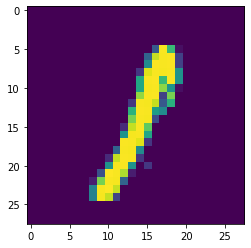



Label tensor(1)


In [ ]:
## Plotting data to make sure it is correct:
x,y = next(iter(train_loader))
plt.imshow(x[0][0].cpu().data.numpy()) #plotting first channel of first image of MNIST
plt.show()
print('Label', y[0])

If you see an image of one of training samples above, then everything is working correctly for the next section.

## 1. Basic Model and Training Functions

**Defining the model:**
Here we define a simple multi-layer perceptron (MLP) model, with two hidden layers and relu activations.

In [ ]:
class Net(nn.Module):
  def __init__(self, input_size, width, num_classes):
    super(Net, self).__init__()

    ##feedfoward layers:
    self.ff1 = nn.Linear(input_size, width) #input

    self.ff2 = nn.Linear(width, width) #hidden layers
    self.ff3 = nn.Linear(width, width)

    self.ff_out = nn.Linear(width, num_classes) #logit layer     

    ##activations:
    self.relu = nn.ReLU()

    #other activations:
    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()

    ## Some normalization functions.
    ## Feel free to add them into the forward pass if you like.
    
    #dropout:
    self.do = nn.Dropout()

    #batch-normalization:
    self.bn1 = nn.BatchNorm1d(width)
    self.bn2 = nn.BatchNorm1d(width)
    self.bn3 = nn.BatchNorm1d(width)

                
  def forward(self, input_data):
    out = self.relu(self.ff1(input_data)) 
    out = self.relu(self.ff2(out)) 
    out = self.relu(self.ff3(out))
    out = self.ff_out(out)
    return out #returns class probabilities for each image


**Instantiating the model:** we instantiate the model with a width of 500 and 10 classes.

In [ ]:
net = Net(input_size = 784, width = 500, num_classes = 10)
if gpu_boole:
  net = net.cuda()

**Defining the optimizer:** we set the optimization procedure as stochastic gradient descent with various parameters. We also define our loss function.

In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr = 0.0025, momentum = 0.9)
loss_metric = nn.CrossEntropyLoss()

**Defining dataset loaders:** here, we define the dataset loaders with a specific batch size of 128 and basic tensor transformation / preprocessing:



In [ ]:
training = dataset.MNIST(root ='./data', transform=transforms.ToTensor(), train=True, download=True)
testing =  dataset.MNIST(root ='./data', transform = transforms.ToTensor(), train=False, download=True)
train_loader = torch.utils.data.DataLoader(dataset=training, batch_size = 128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testing, batch_size = 128, shuffle=False)
test_loader_shuffle = torch.utils.data.DataLoader(dataset=testing, batch_size = 128, shuffle=True)

**Defining training and test loss and accuracy functions:** These functions will be useful in our training loop to view are training and test loss/accuracy at each epoch.

In [ ]:
def train_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in train_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels)
        
    if verbose:
        print('Train accuracy: %f %%' % (100 * correct / total))
        print('Train loss: %f' % (loss_sum.cpu().data.numpy().item() / total))

    return 100.0 * correct / total, loss_sum.cpu().data.numpy().item() / total
    
def test_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in test_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels)

    if verbose:
        print('Test accuracy: %f %%' % (100 * correct / total))
        print('Test loss: %f' % (loss_sum.cpu().data.numpy().item() / total))

    return 100.0 * correct / total, loss_sum.cpu().data.numpy().item() / total


## 2. CNA Functions

Here we define the CNA and CNA-Margin functions.

**Entropy function:**

In [ ]:
def get_entropy(x):
  hist = np.histogram(x, bins=1000, range = (0,1),density=True)
  data = hist[0]
  ent=0
  for i in hist[0]:
      if i!=0:
          ent -= i * np.log2(abs(i))
  return ent

def get_entropy_batch_np(x):
  entropy = []
  for i in range(x.shape[0]):
    entropy.append(get_entropy(x[i]))
  entropy = np.array(entropy)
  return entropy


**CNA Entropy and Slope functions:**

In [ ]:
def get_slopes(x, net):

  activations = []
  def get_activation_sums():
      def hook(model, input, output):
          activations.append(output.detach().view(output.shape[0],-1).sum(dim=1))
      return hook 

  hooks = []
  def register_hooks(module):    
    if any([isinstance(module, nn.Linear), isinstance(module, nn.Conv2d)]):
      handle = module.register_forward_hook(get_activation_sums())
      hooks.append(handle)
    if hasattr(module, 'children'):
      children = list(module.children())
      for i in range(len(children)):
        register_hooks(children[i])  

  register_hooks(net)
  if len(hooks) > 1:
    hooks[-1].remove()

  output = net(x)

  acts = np.array([a.cpu().data.numpy() for a in activations])

  #De-registering hooks:
  for hook in hooks:
    hook.remove()

  def threshold(M):
      Mabs = np.abs(M)
      M[Mabs<0.0000001] = 0
      return M
  
  C = np.array([np.ones(len(acts)),np.arange(1,len(acts)+1)]).transpose()
  Cf = np.linalg.inv((C.T).dot(C)).dot(C.T)
  Cf = threshold(Cf)
  Cf = Cf[1,:]

  S = 0
  for j in range(len(Cf)):
      S += acts[j]*Cf[j]
  
  return S

def get_CNA(x, net):
  entropy = get_entropy_batch_np(x.cpu().data.numpy())
  slopes = get_slopes(x, net)
  return np.corrcoef(entropy,slopes)[0,1]


**CNA Margin sub-functions:**

In [ ]:
def get_slopes_all(data_loader, net, flatten=False):    
  slopes = []
  for x, y in data_loader:
      if flatten:
          x = x.view(x.shape[0],-1)
      if gpu_boole:
          x = x.cuda()
      slopes = slopes + list(get_slopes(x, net))            
  slopes = np.array(slopes)
  return slopes

def get_entropy_all(data_loader):
  entropy = []
  for x, y in data_loader:
      entropy = entropy + list(get_entropy_batch_np(x.cpu().data.numpy()))
  entropy = np.array(entropy)
  return entropy

def running_mean(x, N):
  cumsum = np.cumsum(np.insert(x, 0, 0)) 
  return (cumsum[N:] - cumsum[:-N]) / float(N)

def get_normalized_slope_entropy_curves(net, train_loader, test_loader, flatten=True):
  #Getting slopes and entropy for train and test sets:
  slopes_train = get_slopes_all(train_loader, net, flatten = flatten)
  slopes_test = get_slopes_all(test_loader, net, flatten = flatten)
  entropy_train = get_entropy_all(train_loader)
  entropy_test = get_entropy_all(test_loader)

  #Indices of sorted entropy:
  ent_ind_train = np.argsort(entropy_train)
  ent_ind_test = np.argsort(entropy_test)

  #Smoothing slope and entropy curves:
  K = 25
  slopes_train_smooth, entropy_train_smooth = running_mean(slopes_train[ent_ind_train],K), running_mean(entropy_train[ent_ind_train],K)
  slopes_test_smooth, entropy_test_smooth = running_mean(slopes_test[ent_ind_test],K), running_mean(entropy_test[ent_ind_test],K)

  #Min-max normalization of slopes and entropy w.r.t. training and test sets:
  slopes_min, slopes_max = np.min([slopes_train_smooth.min(),slopes_test_smooth.min()]), np.max([slopes_train_smooth.max(),slopes_test_smooth.max()])
  entropy_min, entropy_max = np.min([entropy_train_smooth.min(),entropy_test_smooth.min()]), np.max([entropy_train_smooth.max(),entropy_test_smooth.max()])  
  slopes_min = np.min([slopes_train_smooth.min(),slopes_test_smooth.min()])
  slopes_train_smooth -= slopes_min
  slopes_test_smooth -= slopes_min
  slopes_max = np.max([slopes_train_smooth.max(),slopes_test_smooth.max()])
  slopes_train_smooth /= slopes_max
  slopes_test_smooth /= slopes_max
  
  entropy_min = np.min([entropy_train_smooth.min(),entropy_test_smooth.min()])
  entropy_train_smooth -= entropy_min
  entropy_test_smooth -= entropy_min
  entropy_max = np.max([entropy_train_smooth.max(),entropy_test_smooth.max()])
  entropy_train_smooth /= entropy_max
  entropy_test_smooth /= entropy_max

  return [slopes_train_smooth, entropy_train_smooth, slopes_test_smooth, entropy_test_smooth]

def curve_est(x, y, x2, y2, points=15): #Function for linear interpolation of curves    
    f = interp1d(x, y)
    f2 = interp1d(x2,y2)
        
    xnew = np.linspace ( min(x), max(x), num = points) 
    xnew2 = np.linspace ( min(x2), max(x2), num = points) 
    
    ynew = f(xnew) 
    ynew2 = f2(xnew2) 
    
    return xnew, ynew, xnew2, ynew2

**CNA-Margin main functions:**

In [ ]:
#CNA-Area. Area between inscribed polygon of slope-entropy train-test curves:
def CNA_A(train_loader, test_loader, net, flatten=True):

  #Estimated, smoothed coordinates of slope-entropy curve:
  xnew, ynew, xnew2, ynew2 = curve_est(*get_normalized_slope_entropy_curves(net, train_loader, test_loader, flatten=True), points = 100)

  #Getting maximum circumscribed polygon:
  array1 = np.array([xnew, ynew]).T
  array2 = np.array([xnew2, ynew2]).T
  array2 = np.flip(array2,axis=0)
  polygon_points = np.concatenate((array1,array2,array1[0].reshape([1,2])),axis=0)
  
  polygon = Polygon(polygon_points)
  area = polygon.area
  
  return area

#Margin calculation. Getting the maximum interclass decision boundary of the network:
def margin_calc(data_loader, net, flatten=True):
    margin = torch.Tensor([])
    if gpu_boole:
        margin = margin.cuda()
    for i, (x, y) in enumerate(data_loader):
        if gpu_boole:
            x, y = x.cuda(), y.cuda()
        if flatten:
            x = x.view(x.shape[0], -1)
        output_m = net(x)
        for k in range(y.size(0)):
            output_m[k, y[k]] = output_m[k,:].min()
            margin = torch.cat((margin, output_m[:, y].diag() - output_m[:, output_m.max(1)[1]].diag()), 0)
    margin = margin.cpu().data.numpy()
    val_margin = np.percentile( margin, 5 )    
    return val_margin

#CNA-Margin. Generalization gap metric based on CNA principles. 
#State-of-the-art for generalization gap prediction (as of 2019):
def CNA_M(train_loader, test_loader, net, flatten=True):
  cna_a = CNA_A(train_loader, test_loader, net, flatten=flatten)
  tr_margin = margin_calc(train_loader, net, flatten=flatten)
  cna_m = cna_a * tr_margin
  return cna_m



**Batch-wise CNA-M Functions:**

In [ ]:
def CNA_M_batch(net, x, y, test_loader, flatten=True):
  for x_test, y_test in test_loader:
    x_test, y_test = x_test, y_test
    break

  if gpu_boole:
    x_test, y_test = x_test.cuda(), y_test.cuda()
  if flatten:
    x_test = x_test.view(x_test.shape[0],-1)

  slopes_train, slopes_test = get_slopes(x, net), get_slopes(x_test, net)
  entropy_train, entropy_test = get_entropy_batch_np(x.cpu().data.numpy()), get_entropy_batch_np(x_test.cpu().data.numpy())

  ##Normalized curves:

  #Indices of sorted entropy:
  ent_ind_train = np.argsort(entropy_train)
  ent_ind_test = np.argsort(entropy_test)

  #Smoothing slope and entropy curves:
  K = 25
  slopes_train_smooth, entropy_train_smooth = running_mean(slopes_train[ent_ind_train],K), running_mean(entropy_train[ent_ind_train],K)
  slopes_test_smooth, entropy_test_smooth = running_mean(slopes_test[ent_ind_test],K), running_mean(entropy_test[ent_ind_test],K)

  #Min-max normalization of slopes and entropy w.r.t. training and test sets:
  slopes_min, slopes_max = np.min([slopes_train_smooth.min(),slopes_test_smooth.min()]), np.max([slopes_train_smooth.max(),slopes_test_smooth.max()])
  entropy_min, entropy_max = np.min([entropy_train_smooth.min(),entropy_test_smooth.min()]), np.max([entropy_train_smooth.max(),entropy_test_smooth.max()])  
  slopes_min = np.min([slopes_train_smooth.min(),slopes_test_smooth.min()])
  slopes_train_smooth -= slopes_min
  slopes_test_smooth -= slopes_min
  slopes_max = np.max([slopes_train_smooth.max(),slopes_test_smooth.max()])
  slopes_train_smooth /= slopes_max
  slopes_test_smooth /= slopes_max
  
  entropy_min = np.min([entropy_train_smooth.min(),entropy_test_smooth.min()])
  entropy_train_smooth -= entropy_min
  entropy_test_smooth -= entropy_min
  entropy_max = np.max([entropy_train_smooth.max(),entropy_test_smooth.max()])
  entropy_train_smooth /= entropy_max
  entropy_test_smooth /= entropy_max

  ## Interpolated Curves:
  x1, y1, x2, y2 = slopes_train_smooth, entropy_train_smooth, slopes_test_smooth, entropy_test_smooth
  points = 15

  f = interp1d(x1, y1)
  f2 = interp1d(x2, y2)
      
  xnew = np.linspace ( min(x1), max(x1), num = points) 
  xnew2 = np.linspace ( min(x2), max(x2), num = points) 
  
  ynew = f(xnew) 
  ynew2 = f2(xnew2)

  ## CNA-Area final calculation:

  #Getting maximum circumscribed polygon:
  array1 = np.array([xnew, ynew]).T
  array2 = np.array([xnew2, ynew2]).T
  array2 = np.flip(array2,axis=0)
  polygon_points = np.concatenate((array1,array2,array1[0].reshape([1,2])),axis=0)
  
  polygon = Polygon(polygon_points)
  area = polygon.area

  ## CNA-Margin:

  ## Margin for batch:
  if gpu_boole:
    x, y = x.cuda(), y.cuda()
  if flatten:
    x = x.view(x.shape[0], -1)
    output_m = net(x)
    for k in range(y.size(0)):
      output_m[k, y[k]] = output_m[k,:].min()
      margin = output_m[:, y].diag() - output_m[:, output_m.max(1)[1]].diag()
  margin = margin.cpu().data.numpy()
  tr_margin = np.percentile( margin, 5 )
  
  cna_m = area * tr_margin

  return cna_m    


## 3. Training Loop

Here, we give the training loop. A number of epochs is set. Loss is recorded and plotted at the end.

We also record the CNA and CNA-Margin values over training.

In [ ]:
#batch-wise boole, whether to calculate CNA metrics per batch or per epoch:
per_batch = True

#number of epochs to train for:
epochs = 5

#defining batch train loss recording arrays for later visualization/plotting:
loss_batch_store = []
CNA_store = []

#CNA-M and generalization gap stores:
gen_gap_store = []
CNA_M_store = []

print("Starting Training")
#training loop:
for epoch in range(epochs):
  time1 = time.time() #timekeeping

  for i, (x,y) in enumerate(train_loader):

    #reshaping to flat shape:
    x = x.view(-1,28*28)

    if gpu_boole:
      x = x.cuda()
      y = y.cuda()

    #loss calculation and gradient update:

    if i > 0 or epoch > 0:
      optimizer.zero_grad()
    outputs = net.forward(x)
    loss = loss_metric(outputs,y)
    loss.backward()

    if i > 0 or epoch > 0:
      loss_batch_store.append(loss.cpu().data.numpy().item())

    ##performing update:
    optimizer.step()

    if per_batch:
      CNA_val = get_CNA(x,net)
      CNA_store.append(CNA_val)

      CNA_M_val = CNA_M_batch(net, x, y, test_loader)
      CNA_M_store.append(CNA_M_val)

    optimizer.zero_grad()      


  print("Epoch",epoch+1,':')
  train_perc, train_loss = train_eval()
  test_perc, test_loss = test_eval()
  gen_gap_val = np.abs(train_loss - test_loss)
  gen_gap_store.append(gen_gap_val)

  CNA_val = get_CNA(x,net)
  CNA_store.append(CNA_val)
  print("CNA Value for Last Minibatch of Epoch:",CNA_val)

  if not per_batch:
    CNA_M_val = CNA_M(train_loader, test_loader, net)
    CNA_M_store.append(CNA_M_val)
  print("CNA-Margin Value for Last Minibatch of Epoch:",CNA_M_val)
  print("Generalization Gap Value for Last Minibatch of Epoch:",gen_gap_val)

  time2 = time.time() #timekeeping
  print('Elapsed time for epoch:',time2 - time1,'s')
  print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')
  print()

## Plotting batch-wise train loss curve:
plt.plot(loss_batch_store, '-o', label = 'train_loss', color = 'blue')
plt.xlabel('Minibatch Number')
plt.ylabel('Mean Train Loss For Minibatch')
plt.title('Train Loss Curve')
plt.legend()
plt.show()

## Plotting epoch-wise/batch-wise CNA curve:
plt.plot(CNA_store, '-o', label = 'cna_val', color = 'orange')
if per_batch:
  plt.xlabel('Minibatch Number')
  plt.ylabel('CNA Value For Minibatch')
else:
  plt.xlabel('Epoch Number')
  plt.ylabel('CNA Value For Epoch')
plt.title('CNA Curve')
plt.legend()
plt.show()

## Plotting epoch-wise/batch-wise CNA-M curve:
plt.plot(running_mean(CNA_M_store,180), '-o', label = 'cna_m_val', color = 'red')
if per_batch:
  plt.xlabel('Minibatch Number')
  plt.ylabel('CNA-M Value For Minibatch')
else:
  plt.xlabel('Epoch Number')
  plt.ylabel('CNA-M Value For Epoch')
plt.title('CNA-Margin Curve')
plt.legend()
plt.show()

## Plotting epoch-wise/batch-wise generalization gap curve:
plt.plot(gen_gap_store, '-o', label = 'gen_gap', color = 'green')
plt.xlabel('Epoch Number')
plt.ylabel('Generalization Gap For Epoch')
plt.title('Generalization Gap Curve')
plt.legend()
plt.show()


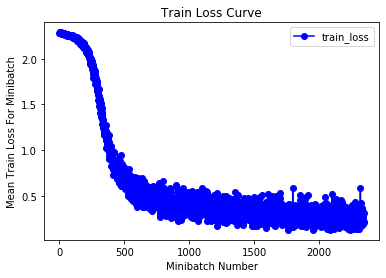

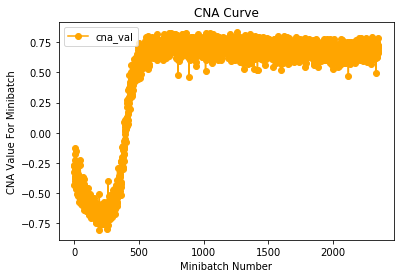

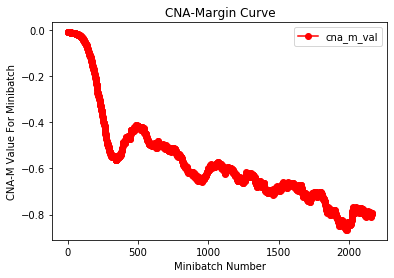

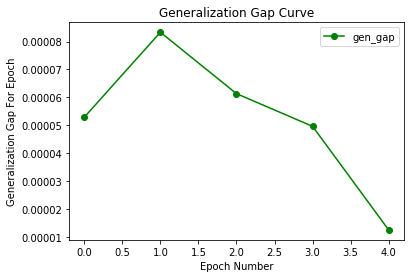

In [ ]:
## Plotting batch-wise train loss curve:
plt.plot(loss_batch_store, '-o', label = 'train_loss', color = 'blue')
plt.xlabel('Minibatch Number')
plt.ylabel('Mean Train Loss For Minibatch')
plt.title('Train Loss Curve')
plt.legend()
plt.show()

## Plotting epoch-wise/batch-wise CNA curve:
plt.plot(CNA_store, '-o', label = 'cna_val', color = 'orange')
if per_batch:
  plt.xlabel('Minibatch Number')
  plt.ylabel('CNA Value For Minibatch')
else:
  plt.xlabel('Epoch Number')
  plt.ylabel('CNA Value For Epoch')
plt.title('CNA Curve')
plt.legend()
plt.show()

## Plotting epoch-wise/batch-wise CNA-M curve:
plt.plot(running_mean(CNA_M_store, 180), '-o', label = 'cna_m_val', color = 'red')
if per_batch:
  plt.xlabel('Minibatch Number')
  plt.ylabel('CNA-M Value For Minibatch')
else:
  plt.xlabel('Epoch Number')
  plt.ylabel('CNA-M Value For Epoch')
plt.title('CNA-Margin Curve')
plt.legend()
plt.show()

## Plotting epoch-wise/batch-wise generalization gap curve:
plt.plot(gen_gap_store, '-o', label = 'gen_gap', color = 'green')
plt.xlabel('Epoch Number')
plt.ylabel('Generalization Gap For Epoch')
plt.title('Generalization Gap Curve')
plt.legend()
plt.show()
